# Test sample and feature weight

This notebook explores whether weighting each sample with the number of events improve the accuracy of the prediction? 
  * What is an appropiate weight for devices without events?
  * Should the weight be capped? 
  * How should it increase with number of events?
  
Unfortunately, various possible weighting scheme (normalized, linear, exponential) all decreased the score. I do not understand this, requires further work and better understanding the the lbfgs solver.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import log_loss
import pickle

In [2]:
dir_in = 'data'
rs = 123

feature_files = ['features_bag_brand',
                 'features_bag_model',
                'features_bag_label_installed',
                'features_bag_app_installed']

# Function to read feature file
def open_feature_file(fname, samples='train'):
    with open(os.path.join(dir_in, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
        return pickle.load(f)

In [3]:
# Calculate CV score on Xtrain, y
def score(X, clf = None, random_state = 123, w = None):
    if not clf: clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs', n_jobs=2)
        
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = X[itrain, :], X[itest, :]
        ytr, yte = y[itrain], y[itest]
        if np.any(w):
            ws = w[itrain]
        else:
            ws = None
            
        clf.fit(Xtr, ytr, sample_weight = ws)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    #print('')
    return log_loss(y, pred)

## Get basescore on installed bag of apps

In [4]:
gatrain = pd.read_csv(os.path.join(dir_in,'gender_age_train.csv'))
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [5]:
fw = [1, 1, 1, 1]
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
# Weird linear scaling of features decreases performance.
# *1.0: Basescore: 2.27402
# *1.1: Basescore: 2.27443
# *1.2: Basescore: 2.27534
# *0.5: Basescore: 2.28733


In [6]:
basescore = score(Xtrain, random_state=rs)
print('Basescore: {:.5f}'.format(basescore))

Basescore: 2.27402


## Test sample weights

In [7]:
# Load event data
events = pd.read_csv(os.path.join(dir_in,'events.csv'))
events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [8]:
nevents = events.groupby('device_id').size().sort_values(ascending=False)
nevents.head(15)

device_id
 1186608308763918427    33426
 3915082290673137129    14568
-1656894751624916732     6731
-6242501228649113250     4150
-8340098378141155823     3973
-3746248670824158209     3907
 2504414082456157897     3804
-3037377082444295812     3534
-17299534936664237       3506
-7369693784883843916     3446
 8339429008953975436     3440
 5083019926611946481     3395
 5375599021847302819     3128
-5105332332397066846     3099
 2771516290634663640     2975
dtype: int64

In [9]:
device_events = pd.merge(gatrain, nevents.to_frame('weights'), 
                          left_on='device_id', right_index=True, 
                          how='left')
device_events.fillna(0, inplace=True)
device_events = device_events['weights']

In [10]:
device_events.max()

4150.0

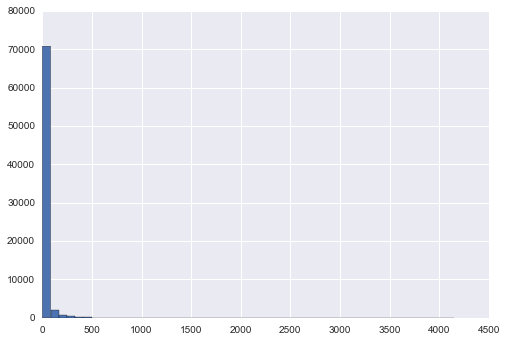

In [11]:
device_events.hist(bins=50)


In [21]:
def event_weight(nevent, cap, lin_factor, exp_factor):
    # 2.27575
    #return 1+normalize(nevent)
    # 2.56681
    #return 1+nevents
    # 2.29549
    #return np.log(normalize(nevents)+1)
    # 2.27513
    #nevent[nevent==200]=0
    #return 1+normalize(nevent)
    # 2.27620
    
    # Cap events
    nevent[nevent>cap] = event_cap
    
    return 1+lin_factor*(normalize(nevent)) ** exp_factor
    # 2.32712
    #nevent[nevent==event_cap]=0
    #return 1+np.sqrt(nevent)
def event_weight_balance(nevent, cap, delta):
    
    w = pd.Series(nevent).copy()
    w[nevent>=cap] = 1 - delta
    
    w[nevent<cap] = 0.9 #1 - float(delta * sum(nevent>=cap)) / sum(nevent<cap) 
    
    return w
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

0.900000000001


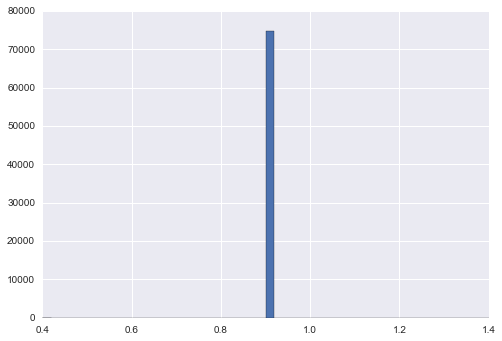

In [16]:
event_weight_balance(device_events, 20, .1).hist(bins=50)
print event_weight_balance(device_events, 20, .1).mean()

In [17]:
newscore = score(Xtrain, random_state=rs, w=event_weight_balance(device_events, 20, .1))
print('Newscore: {:.5f}'.format(newscore))
print('Impact {:.5f}'.format(basescore-newscore))

Newscore: 2.27407
Impact -0.00005


In [22]:
vs = [0.01, 0.02, 0.05]
scores=[]
for v in vs:
    newscore = score(Xtrain, random_state=rs, w=event_weight_balance(device_events, 20, v))
    print('Parameter value: {}'.format(v))
    print('Newscore: {:.5f}'.format(newscore))
    print('Impact {:.5f}'.format(basescore-newscore))
    scores.append(newscore)

Parameter value: 0.01
Newscore: 2.27420
Impact -0.00018
Parameter value: 0.02
Newscore: 2.27416
Impact -0.00014
Parameter value: 0.05
Newscore: 2.27414
Impact -0.00012


In [333]:
vs = [0.2, 0.4, 0.6, 0.8, 1, 2, 3]
scores=[]
for v in vs:
    newscore = score(Xtrain, random_state=rs, w=event_weight(device_events, 2000, 1, v))
    print('Parameter value: {}'.format(v))
    print('Newscore: {:.5f}'.format(newscore))
    print('Impact {:.5f}'.format(basescore-newscore))
    scores.append(newscore)

Process PoolWorker-1189:
Traceback (most recent call last):
  File "/Users/joostbloom/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/joostbloom/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/joostbloom/anaconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/Users/joostbloom/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 359, in get
    return recv()


KeyboardInterrupt: 

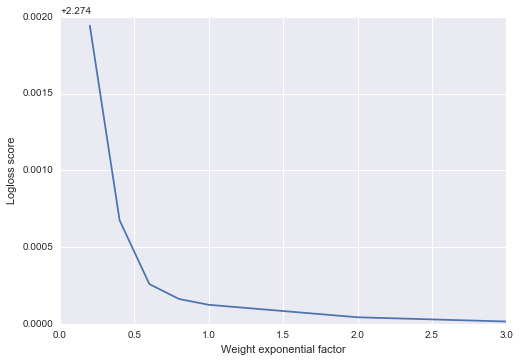

In [325]:
plt.plot(vs, scores)
plt.xlabel('Weight exponential factor')
plt.ylabel('Logloss score')

In [328]:
vs = [0.2, 0.4, 0.6, 0.8, 1, 2, 3]
scores=[]
for v in vs:
    newscore = score(Xtrain, random_state=rs, w=event_weight(device_events, 200, v, 1))
    print('Parameter value: {}'.format(v))
    print('Newscore: {:.5f}'.format(newscore))
    print('Impact {:.5f}'.format(basescore-newscore))
    scores.append(newscore)

Parameter value: 0.2
Newscore: 2.27403
Impact -0.00001
Parameter value: 0.4
Newscore: 2.27405
Impact -0.00003
Parameter value: 0.6
Newscore: 2.27408
Impact -0.00006
Parameter value: 0.8
Newscore: 2.27406
Impact -0.00004
Parameter value: 1
Newscore: 2.27412
Impact -0.00010
Parameter value: 2
Newscore: 2.27420
Impact -0.00018
Parameter value: 3
Newscore: 2.27428
Impact -0.00026


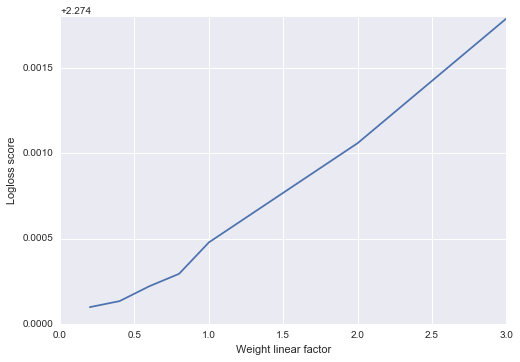

In [327]:
plt.plot(vs, scores)
plt.xlabel('Weight linear factor')
plt.ylabel('Logloss score')

In [323]:
vs = [99999, 10000, 5000, 2000, 1000, 200]
scores=[]
for v in vs:
    newscore = score(Xtrain, random_state=rs, w=event_weight(device_events, v, 0, 2))
    print('Parameter value: {}'.format(v))
    print('Newscore: {:.5f}'.format(newscore))
    print('Impact {:.5f}'.format(basescore-newscore))
    scores.append(newscore)

Process PoolWorker-975:
Traceback (most recent call last):
  File "/Users/joostbloom/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/joostbloom/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/joostbloom/anaconda/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/Users/joostbloom/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 359, in get
    return recv()
KeyboardInterrupt


KeyboardInterrupt: 

## Test cap on number of events

In [317]:
def event_weight_cap(nevent, cap):
    
    # Cap events
    return (nevent<cap).astype(int)

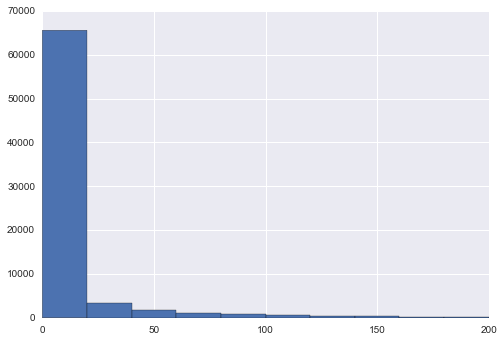

In [210]:
device_events.hist()

In [318]:
device_events.shape

(74645,)

In [319]:
event_weight_cap(device_events,99999).shape

(74645,)

In [320]:
vs = [99999, 5000, 2000, 1000, 500]
scores=[]
for v in vs:
    newscore = score(Xtrain, random_state=rs, w=event_weight_cap(device_events,v))
    print('Parameter value: {}'.format(v))
    print('Newscore: {:.5f}'.format(newscore))
    print('Impact {:.5f}'.format(basescore-newscore))
    scores.append(newscore)

Parameter value: 99999
Newscore: 2.27402
Impact 0.00000
Parameter value: 5000
Newscore: 2.27402
Impact 0.00000
Parameter value: 2000
Newscore: 2.27403
Impact -0.00001
Parameter value: 1000
Newscore: 2.27409
Impact -0.00007
Parameter value: 500
Newscore: 2.27421
Impact -0.00019
